In [1]:
# Library imports

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product

from PIL import Image
import os
import random

2025-03-11 12:09:45.364363: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 12:09:45.379288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741694985.391024    4282 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741694985.394451    4282 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 12:09:45.410935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print("TensorFlow Version:", tf.__version__)
print("Is TensorFlow built with CUDA?", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Device Name:", tf.test.gpu_device_name())
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

TensorFlow Version: 2.18.0
Is TensorFlow built with CUDA? True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device Name: /device:GPU:0


I0000 00:00:1741694986.911683    4282 gpu_device.cc:2022] Created device /device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
# Load the dataset

dataset = pd.read_csv('rare_species 1/metadata.csv')

# Display the first few rows and columns of the dataset

print("Dataset shape:", dataset.shape)
print("Dataset columns:", dataset.columns)

# EOL means Encyclopedia of Life

Dataset shape: (11983, 7)
Dataset columns: Index(['rare_species_id', 'eol_content_id', 'eol_page_id', 'kingdom', 'phylum',
       'family', 'file_path'],
      dtype='object')


Displaying image: rare_species 1/chordata_viperidae/20908310_1057051_eol-full-size-copy.jpg


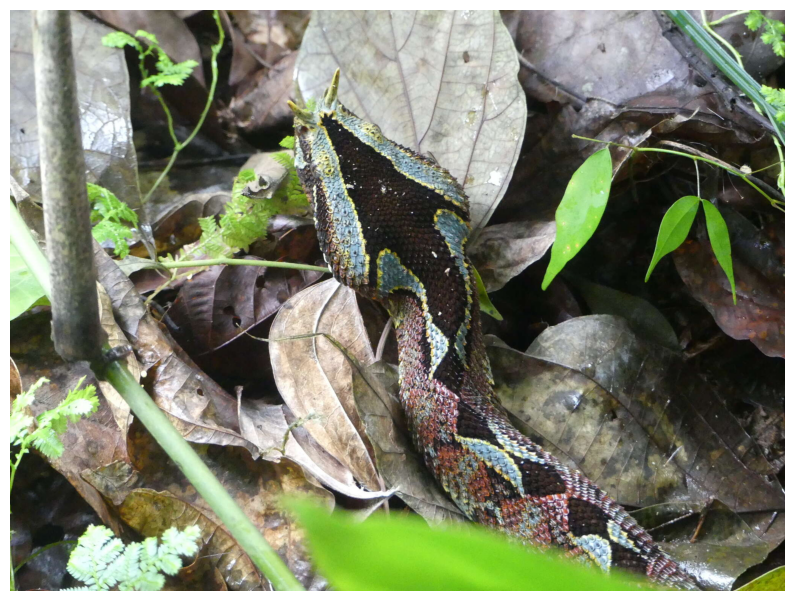

In [4]:
# Path to the folder
image_folder = 'rare_species 1/'

# List all images in the folder
image_files = []
for root, _, files in os.walk(image_folder):
    for file in files:
        if file.endswith(('.jpg')):
            image_files.append(os.path.join(root, file))

# Show example function
def show_image(image_path: str) -> None:
    """
    Displays an image given its path.
    """
    image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')  # Remove axis for cleaner visualization
    plt.show()

# Show an example
if image_files:
    print(f"Displaying image: {image_files[100]}")
    show_image(image_files[100])
else:
    print("No images found in the folder.")

In [5]:
# Selecting the features and the target variable

X = dataset.iloc[:, 1:5].values  # Select features, excluding 'rare_species_id' and 'file_path'
file_paths = dataset['file_path'].values  # Extract file paths as a separate array
y = dataset.iloc[:, 5].values  # 'family' column as the target

# Convert `X` to DataFrame for easier manipulation
X = pd.DataFrame(X, columns=dataset.columns[1:5])

# Add file paths as a new column in `X`
X['file_path'] = file_paths

In [7]:
# Check the unique values of the columns,
# seeing which can be one-hot encoded

#print(dataset['rare_species_id'].unique())
print("eol_content_id unique values:", dataset['eol_content_id'].nunique())
print("eol_page_id unique values:", dataset['eol_page_id'].nunique())
print("kingdom unique values:", dataset['kingdom'].nunique())
print("phylum unique values:", dataset['phylum'].nunique())

print("file_path unique values:", dataset['file_path'].nunique())

print("family unique values:", dataset['family'].nunique())

eol_content_id unique values: 11983
eol_page_id unique values: 400
kingdom unique values: 1
phylum unique values: 5
file_path unique values: 11983
family unique values: 202


In [8]:
# Display 'phylum' unique values
print("phylum unique values:", dataset['phylum'].unique())

phylum unique values: ['mollusca' 'chordata' 'arthropoda' 'echinodermata' 'cnidaria']


In [9]:
# Display 'kingdom' unique values
print("kingdom unique values:", dataset['kingdom'].unique())

# Do we really need the 'kingdom' column?

kingdom unique values: ['animalia']


In [10]:
print(X[:5])  # Display the first 5 rows of X to identify the correct indices

[[12853737 449393 'animalia' 'mollusca']
 [20969394 793083 'animalia' 'chordata']
 [28895411 319982 'animalia' 'chordata']
 [29658536 45510188 'animalia' 'chordata']
 [21252576 7250886 'animalia' 'chordata']]


In [11]:
# Transforming categorical data into numerical data
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(drop="first"), [3])],  # Only select the 'phylum' column
    remainder='passthrough'
)

X = np.array(ct.fit_transform(X))

# Display the transformed feature set
print(X[:5])

[[0.0 0.0 0.0 1.0 12853737 449393 'animalia']
 [1.0 0.0 0.0 0.0 20969394 793083 'animalia']
 [1.0 0.0 0.0 0.0 28895411 319982 'animalia']
 [1.0 0.0 0.0 0.0 29658536 45510188 'animalia']
 [1.0 0.0 0.0 0.0 21252576 7250886 'animalia']]


In [12]:
# Normalize function
def normalize(array: np.ndarray) -> np.ndarray:
    """Converts the type of an ndarray to float32 and normalizes over the pixel range of values"""
    return array.astype("float32") / 255.0

# Target image size
TARGET_SIZE = (128, 128)  # Resize target dimensions

# Load and normalize images
def load_and_normalize(image_paths):
    images = [
        np.array(Image.open(img).convert('RGB').resize(TARGET_SIZE))
        for img in image_paths
    ]
    return normalize(np.array(images))

# Split into train and test sets
train_images, test_images = train_test_split(image_files, test_size=0.2, random_state=42)

# Load and normalize datasets
X_image_train = load_and_normalize(train_images)
X_image_test = load_and_normalize(test_images)

/home/maria/dl/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
# Align metadata based on file paths
# Assuming 'image_files' is a list of paths and 'X' is a DataFrame with a column for file paths
X_metadata_train = X[X['file_path'].isin(train_images)].values
X_metadata_test = X[X['file_path'].isin(test_images)].values

# Reshape image data for concatenation
X_image_train_flat = X_image_train.reshape(X_image_train.shape[0], -1)
X_image_test_flat = X_image_test.reshape(X_image_test.shape[0], -1)

# Combine metadata and image data
X_train = np.concatenate([X_metadata_train, X_image_train_flat], axis=1)
X_test = np.concatenate([X_metadata_test, X_image_test_flat], axis=1)

# Display combined data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Display sample images
def show_images(images, n=5):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(TARGET_SIZE + (3,)))
        plt.axis('off')
    plt.show()

print("Displaying sample train images:")
show_images(X_image_train)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Displaying sample train images:


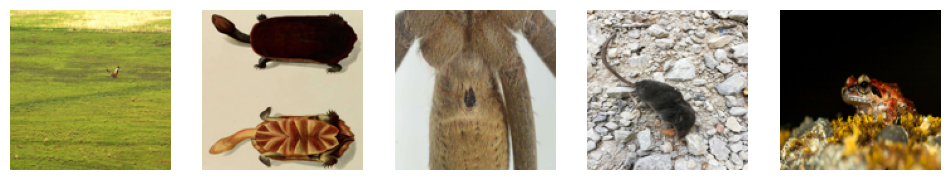

In [14]:
# Display sample images
def show_images(images, n=5):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

print("Displaying sample train images:")
show_images(X_train)

Displaying sample train images:


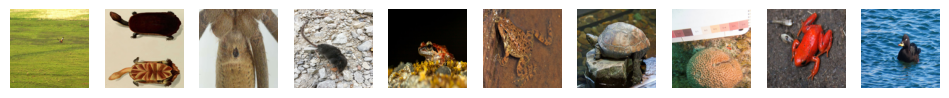

In [15]:
# Display sample images
def show_images(images, n=10):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

print("Displaying sample train images:")
show_images(X_train)